In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.fftpack import * 

## 2D DCT get 1D spectrum
按照Denis 2002的方法进行2D dct的谱合并，制作1D谱分析

## 数据读入

In [3]:
ke_sum = {}
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['rcm'] = ds_ke_sum['vertical integration Ke']

dir_out = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['vr'] = ds_ke_sum['vertical integration Ke']

# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
var_rmnan = {}
var_rmnan['vr'] = ke_sum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
var_rmnan['rcm'] = ke_sum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

## DCTN

In [4]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
res_dctn = {}
res_dctn['vr'] = dctn(var_rmnan['vr'].values, type = 2, axes = [1,2])
res_dctn['rcm'] = dctn(var_rmnan['rcm'].values, type = 2, axes = [1,2])

# 添加维度参数
ntime = res_dctn['vr'].shape[0]
nlat  = res_dctn['vr'].shape[1]
nlon  = res_dctn['vr'].shape[2]
# 添加频谱参数


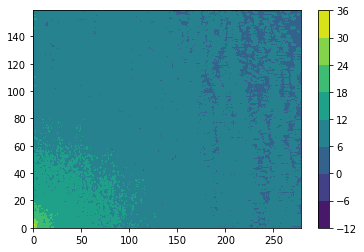

In [5]:
# 简单检查2D谱
plt.contourf(np.log(np.abs(res_dctn['vr'][:,:].mean(axis=0)**2)))
plt.colorbar()

## 从2D谱方位角求和获得1D谱

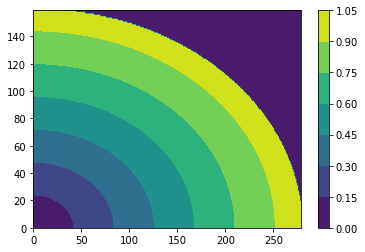

In [37]:
# nlat = 160 (miner)
# nlon = 280
Y, X     = np.ogrid[0:nlat, 0:nlon]
r        = np.hypot(X, Y).astype(np.int)
alpha_2d =  np.empty(shape=r.shape)
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        alpha_2d[ilat, ilon] = np.sqrt( ilon**2/nlon**2 + ilat**2/nlat**2 )
# plt.contourf(alpha_2d)
# plt.colorbar()
alpha_1d = np.arange(1,nlat+1, 1) / nlat
domain_lon_range = 3839. # km
delta = domain_lon_range / nlon
# 2*delta / alpha_1d
alpha_2d = np.where(alpha_2d<=1, alpha_2d, 0)
plt.contourf(alpha_2d)
plt.colorbar()

In [85]:
dctn_1d =  np.empty(shape=nlat)
for i in range(0, nlat - 1):
    sel_index  = (alpha_2d >= alpha_1d[i]) & (alpha_2d < alpha_1d[i + 1])
    dctn_1d[i] = res_dctn['vr'][0][sel_index].sum()

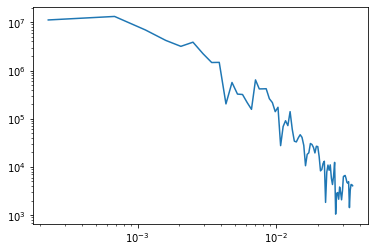

In [111]:
# dctn_1d
N = dctn_1d.shape[0]
variance1D = np.empty(N//2)
for i in range(0, N//2):
    variance1D[i] = dctn_1d[i*2]**2 + 0.5 * dctn_1d[i*2 - 1]**2 + 0.5 * dctn_1d[i*2 + 1]**2

plt.plot(1./(2*delta / alpha_1d)[0:-4:2], np.sqrt(variance1D[0:-2]))
plt.yscale('log')
plt.xscale('log')

<ipython-input-92-66fd9916315c>:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(range(1,nlat+1),1./nlat/nlat*np.sqrt(dctn_1d))


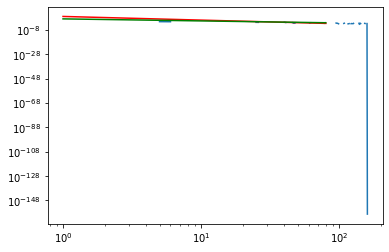

In [92]:
# np.unique(r)
# plt.plot(np.unique(r),np.abs(psd1D))
plt.plot(range(1,nlat+1),1./nlat/nlat*np.sqrt(dctn_1d))
xf = np.arange(1,nlat)
yref_synop = xf[0:nlat//2] ** (-3.) * 1e3
yref_meso  = xf[0:nlat//2] ** (-5./3) * 1e1
plt.plot(xf[0:nlat//2], yref_synop,color='r')
plt.plot(xf[0:nlat//2], yref_meso,color='g')
plt.yscale('log')
plt.xscale('log')

In [81]:
sel_index = (alpha_2d >= alpha_1d[50]) & (alpha_2d < alpha_1d[51])
# plt.contourf(sel_index)
# sel_index.shape
res_dctn['vr'][0][sel_index].sum()

73066.27192514508